In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import rcParams
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import to_categorical

from numpy.random import seed
seed(7)
from tensorflow import set_random_seed
set_random_seed(11)



In [28]:
SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]

In [29]:
# load  dataset
df = pd.read_csv('/home/francovm/Projects/SSE/data/processed/input_data_shifted_40.csv', sep='\t', encoding='utf-8', index_col=0)


In [30]:
input_X = df.loc[:, df.columns != 'Events'].values  # converts the df to a numpy array
input_y = df['Events'].values

n_features = input_X.shape[1]  # number of features

print(input_X.shape,input_y.shape)

(219861, 3) (219861,)


# Temporalize data

In [31]:
def temporalize(X, y, lookback):
    X = []
    y = []
    for i in range(len(input_X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(input_X[[(i+j+1)], :])
        X.append(t)
        y.append(input_y[i+lookback+1])
    return X, y


In [32]:
# Temporalize the data

lookback = 20
X, y = temporalize(X = input_X, y = input_y, lookback = lookback)



# Split into Test, valid and train

In [33]:
#Split into Test, valid and train

X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=DATA_SPLIT_PCT, random_state=SEED)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=DATA_SPLIT_PCT, random_state=SEED)

## Separate negatives and positives values

In [ ]:
X_train_y0 = X_train[y_train==0.]
X_train_y1 = X_train[y_train==1.]

X_valid_y0 = X_valid[y_valid==0.]
X_valid_y1 = X_valid[y_valid==1.]

In [34]:
# Reshape the arrays

X_train = X_train.reshape(X_train.shape[0], lookback, n_features)
X_train_y0 = X_train_y0.reshape(X_train_y0.shape[0], lookback, n_features)
X_train_y1 = X_train_y1.reshape(X_train_y1.shape[0], lookback, n_features)

X_valid = X_valid.reshape(X_valid.shape[0], lookback, n_features)
X_valid_y0 = X_valid_y0.reshape(X_valid_y0.shape[0], lookback, n_features)
X_valid_y1 = X_valid_y1.reshape(X_valid_y1.shape[0], lookback, n_features)b

X_test = X_test.reshape(X_test.shape[0], lookback, n_features)

In [35]:
y_train.shape

(140697,)

In [36]:
## To Categorical Data

# y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)
# y_valid = to_categorical(y_valid)

# print(y_valid.shape, y_test.shape, y_train.shape)

In [37]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], 1
print(n_timesteps,n_features,n_outputs)

20 3 1


# Stardarization

In [38]:
def flatten(X):
    '''
    Flatten a 3D array.
    
    Input
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    
    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    '''
    Scale 3D array.

    Inputs
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    scaler       A scaler object, e.g., sklearn.preprocessing.StandardScaler, sklearn.preprocessing.normalize
    
    Output
    X            Scaled 3D array.
    '''
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

In [39]:
# Initialize a scaler using the training data.
# scaler = StandardScaler().fit(flatten(X_train))

In [40]:
# Standarize the input

# X_train_scaled = scale(X_train, scaler)
# X_valid_scaled = scale(X_valid, scaler)
# X_test_scaled = scale(X_test, scaler)

### Test Standarization

In [41]:
# a = flatten(X_train_scaled)
# print('colwise mean', np.mean(a,axis=0).round(6))
# print('colwise variance', np.var(a, axis=0))



# Model training

Training models (Use it)


In [45]:
# Parameters

verbose, epochs, batch_size = 1, 100, 64


model = Sequential()
model.add(LSTM(50, input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
#     model.add(Dense(n_outputs, activation='softmax'))
model.add(Dense(n_outputs, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


#set early stopping monitor so the model stops training when it won't improve anymore
early_stopping_monitor = EarlyStopping(patience=5)

# fit network
history = model.fit(X_train_y0, X_train_y0, epochs=epochs, batch_size=batch_size,validation_data=(X_valid_y0, X_valid_y0), verbose=verbose,
                    callbacks=[early_stopping_monitor])


# evaluate model
# accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=verbose)

Train on 140697 samples, validate on 35175 samples
Epoch 1/100
140697/140697 [==============================] - 130s 925us/step - loss: 0.1454 - acc: 0.9661 - val_loss: 0.1275 - val_acc: 0.9709
Epoch 2/100
140697/140697 [==============================] - 125s 887us/step - loss: 0.1329 - acc: 0.9693 - val_loss: 0.1267 - val_acc: 0.9709
Epoch 3/100
140697/140697 [==============================] - 127s 905us/step - loss: 0.1309 - acc: 0.9693 - val_loss: 0.1243 - val_acc: 0.9709
Epoch 4/100
140697/140697 [==============================] - 125s 889us/step - loss: 0.1294 - acc: 0.9692 - val_loss: 0.1234 - val_acc: 0.9710
Epoch 5/100
140697/140697 [==============================] - 129s 919us/step - loss: 0.1282 - acc: 0.9693 - val_loss: 0.1247 - val_acc: 0.9711
Epoch 6/100
140697/140697 [==============================] - 124s 880us/step - loss: 0.1274 - acc: 0.9693 - val_loss: 0.1200 - val_acc: 0.9713
Epoch 7/100
140697/140697 [==============================] - 126s 894us/step - loss: 0.1265

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


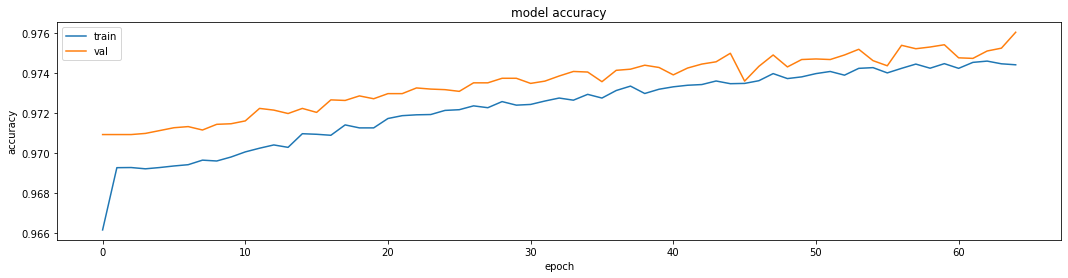

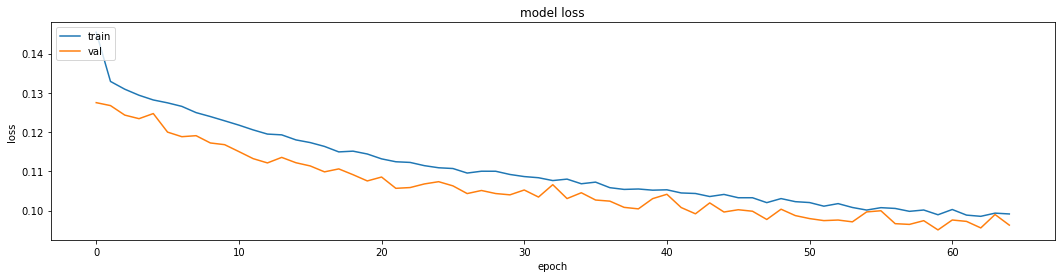

In [48]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

# Get current size
fig_size = plt.rcParams["figure.figsize"]
#  Set figure width to 18 and height to 4
fig_size[0] = 18
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

plt.savefig('/home/francovm/Projects/SSE/data/Visualization/LSTM-40days-acc-shifted.png')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
 # Get current size
fig_size = plt.rcParams["figure.figsize"]

# Set figure width to 18 and height to 4
fig_size[0] = 18
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

plt.savefig('/home/francovm/Projects/SSE/data/Visualization/LSTM-40days-loss-shifted_40.png')
plt.show()

# Save Model

In [49]:
# save model and architecture to single file
# model.save("/home/francovm/Projects/SSE/models/Binary_clasifier/Binary_clasifier_LSTM_SSE_40days-shifted.h5")


# Sanity check

Doing a sanity check by validating the reconstruction error on the train data. Here we will reconstruct the entire train data with both 0 and 1 labels.

**Expectation**: the reconstruction error of 0 labeled data should be smaller than 1.

**Caution**: do not use this result for model evaluation. It may result into overfitting issues.

In [ ]:
train_x_predictions = lstm_autoencoder.predict(X_train)
mse = np.mean(np.power(flatten(X_train) - flatten(train_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_train.tolist()})

groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

# Predictions using the Autoencoder

In [ ]:
valid_x_predictions = lstm_autoencoder.predict(X_valid)
mse = np.mean(np.power(flatten(X_valid) - flatten(valid_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_valid.tolist()})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [ ]:
test_x_predictions = lstm_autoencoder.predict(X_test)
mse = np.mean(np.power(flatten(X_test) - flatten(test_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test.tolist()})

threshold_fixed = 0.3 # Definir!
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [ ]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]

In [ ]:
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()